## Subset xarray datasets

This notebook will explore some of the ways we can subset Xarray Datasets. In particular, we will look at subsetting by variable, by time, and spatial subsetting. 

First, set up the Cecil client and load the dataset of interest. This notebook will use Planet's [Forest Carbon Monitoring](https://docs.cecil.earth/Forest-Carbon-Monitoring-111ef16bbbe4817aa1a8dce6d9216665) dataset to demonstrate the subsetting methods below, but you can change the data request id below to load one of your own datasets and run the notebook yourself. 

In [1]:
import cecil
import xarray
import matplotlib.pyplot as plt

client = cecil.Client()

ds = client.load_xarray('c572bb90-84b8-42f1-884a-94f83acb6a5b')
ds

<xarray.Dataset> Size: 27MB
Dimensions:                                                  (x: 439, y: 361,
                                                              time: 14)
Coordinates:
  * x                                                        (x) float64 4kB ...
  * y                                                        (y) float64 3kB ...
    spatial_ref                                              int64 8B 0
  * time                                                     (time) datetime64[ns] 112B ...
Data variables:
    canopy_cover_uncertainty_lower_bound                     (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    canopy_cover_uncertainty_upper_bound                     (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    canopy_cover                                             (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    aboveground_live_carbon_density                          (time, y, x) int16 4MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    aboveground_live_carbon_density_uncertainty_upper_bound  (time, y, x) int16 4MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    aboveground_live_carbon_density_uncertainty_lower_bound  (time, y, x) int16 4MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    canopy_height_uncertainty_lower_bound                    (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    canopy_height_uncertainty_upper_bound                    (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    canopy_height                                            (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
Attributes:
    provider_name:    Planet
    dataset_id:       4d8bd6ba-b751-4c46-8e70-5000e6d8b212
    dataset_name:     Forest Carbon Monitoring
    dataset_crs:      EPSG:4326
    aoi_id:           7dbbf7c3-0447-45a7-8849-e031c6099c1c
    data_request_id:  c572bb90-84b8-42f1-884a-94f83acb6a5b

### Subset by variable
Selecting a single variable returns a 3D DataArray object of that variable for all available timesteps. 

In [2]:
subset = ds['canopy_cover']
print(subset)

<xarray.DataArray 'canopy_cover' (time: 14, y: 361, x: 439)> Size: 2MB
dask.array<concatenate, shape=(14, 361, 439), dtype=uint8, chunksize=(1, 361, 439), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 4kB 132.5 132.5 132.5 132.5 ... 132.5 132.5 132.5
  * y            (y) float64 3kB -12.72 -12.72 -12.72 ... -12.73 -12.73 -12.73
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 112B 2020-12-21 2021-03-21 ... 2024-03-21
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0


We can also pass a list of variables to select multiple at once.

In [3]:
subset = ds[['canopy_cover', 'canopy_height']]
print(subset.data_vars)

Data variables:
    canopy_cover   (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    canopy_height  (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>


Finally, if we wanted to specify variables to drop from the dataset, rather than variables to keep, we can use the `drop_vars()` function. In this example, we drop any variables with 'uncertainty' in their name. 

In [4]:
vars_to_drop = [v for v in ds.data_vars if 'uncertainty' in v]
subset = ds.drop_vars(vars_to_drop)
print(subset.data_vars)

Data variables:
    canopy_cover                     (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    aboveground_live_carbon_density  (time, y, x) int16 4MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>
    canopy_height                    (time, y, x) uint8 2MB dask.array<chunksize=(1, 361, 439), meta=np.ndarray>


### Subset by time
For datasets with a time dimension, we can also subset by time.

We can either subset an entire dataset for a certain timestep or time range to return all variables for only a specific point in time, or further subset a single variable to get one 2D DataArray. 

Note that this dataset is quarterly, so there are four timesteps available for the year 2022 (2022-03-21, 2022-06-21, 2022-09-21, and 2022-12-21). Filtering for '2022' returns all variables for all four of these timesteps. 

In [5]:
subset = ds.sel(time='2022')
print(subset['time'].values)

['2022-03-21T00:00:00.000000000' '2022-06-21T00:00:00.000000000'
 '2022-09-21T00:00:00.000000000' '2022-12-21T00:00:00.000000000']


It's also possible to select a specific timestep by providing an index rather than the time value. 

In [6]:
subset = ds.isel(time=0)
print(subset['time'].values)

2020-12-21T00:00:00.000000000


### Spatial subsetting

All datasets delivered through Cecil have x and y dimensions. This means it's also possible to subset datasets spatially by providing a specific x/y coordinate, or a bounding box.

We can pass an x and y coordinate of some location within the AOI to pull the data through time for a single pixel. Note that we specify `method='nearest'` to allow xarray to return the data for the pixel that is closest to the exact coordinates.

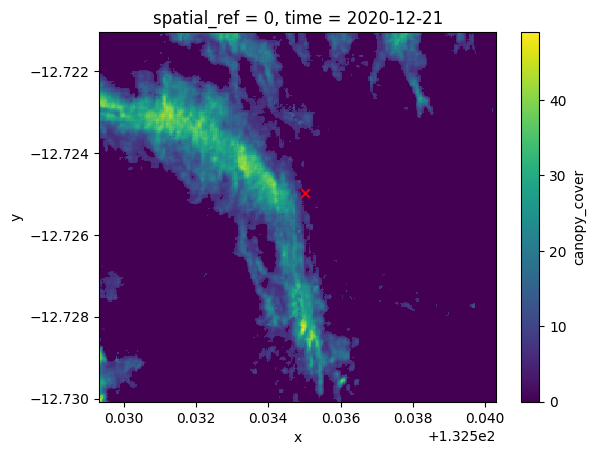

In [7]:
# Select all data for one pixel.
subset = ds.sel(x=132.535, y=-12.725, method='nearest')

# Plot a variable from the original dataset.
ds['canopy_cover'].isel(time=0).plot()

# Add a marker to visualize the selected pixel within the AOI.
plt.scatter(subset.x, subset.y, color='red', marker='x')

Alternatively, we can specify a bounding box within which to select data. This can be useful to try analyses or visualisations on smaller subsets of the data before applying it across an entire AOI. 

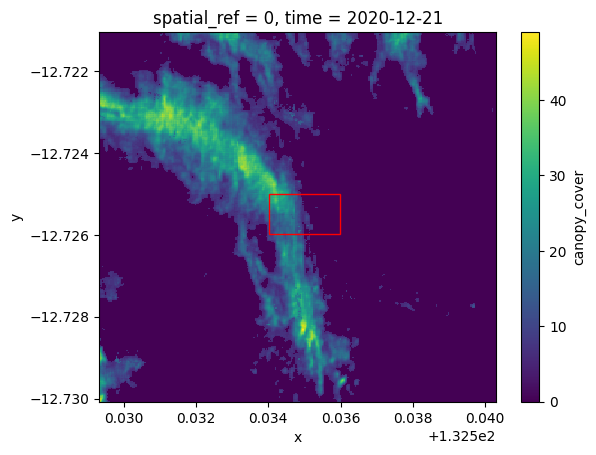

In [8]:
# Select all data within a bounding box.
x_min, x_max = 132.534, 132.536
y_min, y_max = -12.725, -12.726
subset = ds.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))

# Plot a variable from the original dataset.
ds['canopy_cover'].isel(time=0).plot()

# Highlight subset area on top of original data.
ax = plt.gca()
ax.add_patch(plt.Rectangle(
    (subset.x.min(), subset.y.min()), 
    subset.x.max() - subset.x.min(), 
    subset.y.max() - subset.y.min(),
    fill=False, edgecolor='red'))